#### these scripts will mismatch original BERT vocab file

In [ ]:
from vocab_mismatch_utils import *
from data_formatter_utils import *
from datasets import DatasetDict
from datasets import Dataset
from datasets import load_dataset
import transformers
import pandas as pd
import operator
from collections import OrderedDict
from tqdm import tqdm, trange

import collections
import os
import unicodedata
from typing import List, Optional, Tuple

from transformers.tokenization_utils import PreTrainedTokenizer, _is_control, _is_punctuation, _is_whitespace
from transformers.utils import logging
import torch
logger = logging.get_logger(__name__)
import numpy as np
import copy
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from word_forms.word_forms import get_word_forms

seed = 42
# set seeds again at start
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

from functools import partial

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman',
        'size'   : 30}
plt.rc('font', **font)

In [252]:
# this tokenizer helps you to get piece length for each token
modified_tokenizer = ModifiedBertTokenizer(
    vocab_file="../data-files/bert_vocab.txt")
modified_basic_tokenizer = ModifiedBasicTokenizer()

# translator to try it out!
def corrupt_translator(in_string, tokenizer, vocab_match):
    tokens = tokenizer.tokenize(in_string)
    translate_tokens = [vocab_match[t] for t in tokens]
    out_string = " ".join(translate_tokens).replace(" ##", "").strip()
    return out_string

def token_stats_mapping(task, example):
    if task == "sst3" or task == "wiki-text":
        original_sentence = example['text']
        if len(original_sentence.strip()) != 0:
            tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
            for token, pieces in token_dict.items():
                if token in token_frequency_map.keys():
                    token_frequency_map[token] = token_frequency_map[token] + 1
                else:
                    token_frequency_map[token] = 1
                _len = len(pieces)
                if _len in token_by_length.keys():
                    if token not in token_by_length[_len]:
                        token_by_length[_len].append(token)
                else:
                    token_by_length[_len] = [token]
    elif task == "cola":
        original_sentence = example['sentence']
        tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
        for token, pieces in token_dict.items():
            if token in token_frequency_map.keys():
                token_frequency_map[token] = token_frequency_map[token] + 1
            else:
                token_frequency_map[token] = 1
            _len = len(pieces)
            if _len in token_by_length.keys():
                if token not in token_by_length[_len]:
                    token_by_length[_len].append(token)
            else:
                token_by_length[_len] = [token]
    elif task == "mrpc":
        original_sentence = example['sentence1']
        tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
        for token, pieces in token_dict.items():
            if token in token_frequency_map.keys():
                token_frequency_map[token] = token_frequency_map[token] + 1
            else:
                token_frequency_map[token] = 1
            _len = len(pieces)
            if _len in token_by_length.keys():
                if token not in token_by_length[_len]:
                    token_by_length[_len].append(token)
            else:
                token_by_length[_len] = [token]
                
        original_sentence = example['sentence2']
        tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
        for token, pieces in token_dict.items():
            if token in token_frequency_map.keys():
                token_frequency_map[token] = token_frequency_map[token] + 1
            else:
                token_frequency_map[token] = 1
            _len = len(pieces)
            if _len in token_by_length.keys():
                if token not in token_by_length[_len]:
                    token_by_length[_len].append(token)
            else:
                token_by_length[_len] = [token]
    return example

def token_lemma_mapping(word_dict):
    token_lemma_map = {}
    for k, v in word_dict.items():
        external_forms = get_word_forms(k)
        all_lemmas = set([])
        for e_k, e_v in external_forms.items():
            all_lemmas = all_lemmas.union(e_v)
        token_lemma_map[k] = all_lemmas
    return token_lemma_map

def generate_vocab_match_frequency_iv(token_by_length, token_frequency_map, token_lemma_map):
    vocab_match = {}
    for _, tokens in token_by_length.items():
        tokens_copy = copy.deepcopy(tokens)
        
        # token_frequency_map, token_lemma_map)
        
        token_freq_tu = []
        for t in tokens:
            token_freq_tu.append((t, token_frequency_map[t]))
        token_freq_tu = sorted(token_freq_tu, key=operator.itemgetter(1), reverse=True)
        
        matched_to = set([])
        for i in trange(0, len(token_freq_tu)):
            found = False
            for j in range(0, len(token_freq_tu)):
                word_i = token_freq_tu[i][0]
                word_j = token_freq_tu[j][0]
                if i != j and word_j not in matched_to and \
                    len(token_lemma_map[word_i].intersection(token_lemma_map[word_j])) == 0 and \
                    levenshteinDistance(word_i, word_j) > 0.3:
                    matched_to.add(word_j)
                    vocab_match[word_i] = word_j
                    found = True
                    break
            if not found:
                vocab_match[word_i] = word_i
            
    return vocab_match

def generate_vocab_match_low_band_oov(task_token_frequency_map, wiki_token_frequency_map):
    """
    we are not even considering length here, may need to consider as a factor
    """
    tokens = list(task_token_frequency_map.keys())
    tokens_copy = copy.deepcopy(tokens)
    random.shuffle(tokens_copy)
    low_band_freq_vocab = []
    for k, v in wiki_token_frequency_map.items():
        if v <= 2 and k not in task_token_frequency_map.keys():
            low_band_freq_vocab.append(k)
    random.shuffle(low_band_freq_vocab)
    vocab_match = {}
    for i in range(len(tokens)):
        vocab_match[tokens[i]] = low_band_freq_vocab[i]
    return vocab_match

def plot_dist(vocab, map1, map2):
    freq_diff = []
    for k, v in vocab.items():
        diff = abs(map1[k] - map2[v])
        # print(diff)
        freq_diff.append(diff)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    g = ax.hist(freq_diff, bins=100, facecolor='r')
    plt.grid(True)
    plt.grid(color='black', linestyle='-.')
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()
    
def random_corrupt(tokenizer, vocab_match, example):
    original_sentence = example['text']
    corrupted_sentence = corrupt_translator(original_sentence, tokenizer, vocab_match)
    example['text'] = corrupted_sentence
    return example

def generate_vocab_match_high_band_oov(task_token_frequency_map, wiki_token_frequency_map):
    """
    we are not even considering length here, may need to consider as a factor
    """
    high_band_freq_vocab = []
    count = len(task_token_frequency_map)
    for k, v in wiki_token_frequency_map.items():
        if count == 0:
            break
        if k in task_token_frequency_map.keys():
            continue
        high_band_freq_vocab.append(k)
        count -= 1
    high_band_freq_vocab = high_band_freq_vocab[::-1]
    vocab_match = {}
    tokens = list(task_token_frequency_map.keys())
    for i in range(len(tokens)):
        vocab_match[tokens[i]] = high_band_freq_vocab[i]
    return vocab_match

### Get mismatched vocab!

**Wiki-Text Frequency for OOV**: Ger frequency for out-of-vocab words in wiki-text

In [ ]:
wiki_datasets = DatasetDict.load_from_disk(os.path.join(external_output_dirname, "wikitext-15M"))
wiki_train_df = wiki_datasets['train']
wiki_eval_df = wiki_datasets['validation']
wiki_test_df = wiki_datasets['test']

token_frequency_map = {} # overwrite this everytime for a new dataset
wiki_train_df = wiki_train_df.map(partial(token_frequency_mapping, "wiki-text"))
wiki_eval_df = wiki_eval_df.map(partial(token_frequency_mapping, "wiki-text"))
wiki_test_df = wiki_test_df.map(partial(token_frequency_mapping, "wiki-text"))
token_frequency_map = sorted(token_frequency_map.items(), key=operator.itemgetter(1), reverse=True) # copy
wiki_token_frequency_map = OrderedDict(token_frequency_map)

In [142]:
# task setups
task_name = "sst3"
FILENAME_CONFIG = {
    "sst3" : "sst-tenary"
}

# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                    f"{FILENAME_CONFIG[task_name]}-train.tsv"), 
                       delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                   f"{FILENAME_CONFIG[task_name]}-dev.tsv"), 
                      delimiter="\t")
test_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                   f"{FILENAME_CONFIG[task_name]}-test.tsv"), 
                      delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)
test_df = Dataset.from_pandas(test_df)

token_by_length = {} # overwrite this everytime for a new dataset
token_frequency_map = {} # overwrite this everytime for a new dataset
train_df = train_df.map(partial(token_stats_mapping, task_name))
eval_df = eval_df.map(partial(token_stats_mapping, task_name))
test_df = test_df.map(partial(token_stats_mapping, task_name))
task_token_by_length = OrderedDict(token_by_length)
task_token_frequency_map = sorted(token_frequency_map.items(), key=operator.itemgetter(1), reverse=True)
task_token_frequency_map = OrderedDict(task_token_frequency_map)
task_token_lemma_map = token_lemma_mapping(vocab_match_by_piece_length)

#### S1: Frequency-matched in-vocab swap

In [143]:
vocab_match_frequency_iv = \
    generate_vocab_match_frequency_iv(task_token_by_length, 
                                      task_token_frequency_map, 
                                      task_token_lemma_map)

100%|██████████| 1/1 [00:00<00:00, 5652.70it/s]


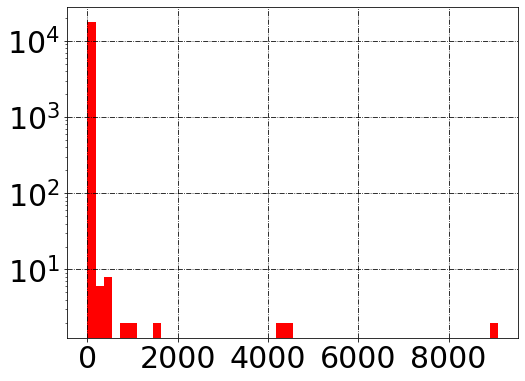

In [152]:
plot_dist(vocab_match_frequency_iv, task_token_frequency_map, task_token_frequency_map)

#### S2: Frequency unmatched in-vocab swap

In [246]:
def generate_vocab_match_no_frequency_iv(token_by_length, token_frequency_map):
    tokens = list(task_token_frequency_map.keys())
    tokens_copy = copy.deepcopy(tokens)
    tokens_copy = tokens_copy[::-1]
    vocab_match = {}
    for i in range(len(tokens)):
        vocab_match[tokens[i]] = tokens_copy[i]
    return vocab_match

vocab_match_no_frequency_iv = \
    generate_vocab_match_no_frequency_iv(task_token_by_length, 
                                       task_token_frequency_map)

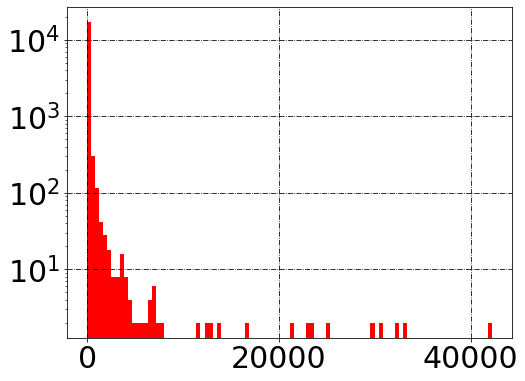

In [253]:
plot_dist(vocab_match_no_frequency_iv, task_token_frequency_map, task_token_frequency_map)

In [251]:
corrupted_train_dataset = train_df.map(partial(random_corrupt, 
                                               modified_basic_tokenizer, 
                                               vocab_match_no_frequency_iv))
corrupted_validation_dataset = eval_df.map(partial(random_corrupt, 
                                                   modified_basic_tokenizer, 
                                                   vocab_match_no_frequency_iv))
corrupted_test_dataset = test_df.map(partial(random_corrupt, 
                                             modified_basic_tokenizer, 
                                             vocab_match_no_frequency_iv))

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk(f"../data-files/{FILENAME_CONFIG[task_name]}-corrupted-S2")

#### S3: Low-band Frequency-matched out-of-vocab swap
all token maps to very lower frequency token in English texts

In [236]:
vocab_match_low_band_oov = generate_vocab_match_low_band_oov(task_token_frequency_map, wiki_token_frequency_map)

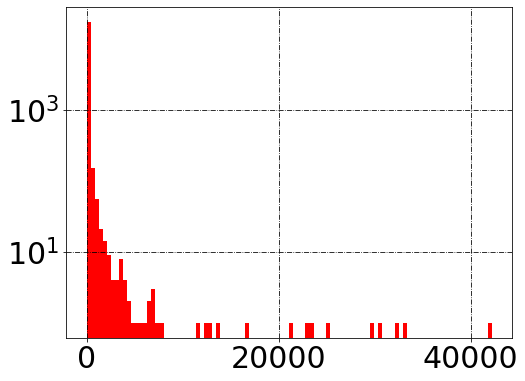

In [237]:
plot_dist(vocab_match_low_band_oov, task_token_frequency_map, wiki_token_frequency_map)

In [238]:
corrupted_train_dataset = train_df.map(partial(random_corrupt, 
                                               modified_basic_tokenizer, 
                                               vocab_match_low_band_oov))
corrupted_validation_dataset = eval_df.map(partial(random_corrupt, 
                                                   modified_basic_tokenizer, 
                                                   vocab_match_low_band_oov))
corrupted_test_dataset = test_df.map(partial(random_corrupt, 
                                             modified_basic_tokenizer, 
                                             vocab_match_low_band_oov))

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk(f"../data-files/{FILENAME_CONFIG[task_name]}-corrupted-S3")

#### S4: Micro-frequency mismatch out-of-vocab swap
all token maps to very lower frequency token in English text

In [254]:
vocab_match_high_band_oov = \
    generate_vocab_match_high_band_oov(task_token_frequency_map, 
                                       wiki_token_frequency_map)

In [255]:
corrupted_train_dataset = train_df.map(partial(random_corrupt, 
                                               modified_basic_tokenizer, 
                                               vocab_match_high_band_oov))
corrupted_validation_dataset = eval_df.map(partial(random_corrupt, 
                                                   modified_basic_tokenizer, 
                                                   vocab_match_high_band_oov))
corrupted_test_dataset = test_df.map(partial(random_corrupt, 
                                             modified_basic_tokenizer, 
                                             vocab_match_high_band_oov))

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk(f"../data-files/{FILENAME_CONFIG[task_name]}-corrupted-S4")

#### S5: High-band frequency vocab swap
TODO: currently, don't have a good way of doing this.

#### S6: Low-band frequency vocab swap with In-sentence
This is controlled by a flag.

#### S7: Dangerous Zone, let me swap everything randomly
random everything!

In [209]:
def choas_corrupt(tokens_pool, tokenizer, example):
    original_sentence = example['text']
    tokens = tokenizer.tokenize(original_sentence)
    corrupted_sentence = random.choices(tokens_pool, k=len(tokens))
    out_string = " ".join(corrupted_sentence).replace(" ##", "").strip()
    example['text'] = out_string
    return example
    
tokens_pool = list(wiki_token_frequency_map.keys())
random.shuffle(tokens_pool)
tokens_pool = tokens_pool[:len(task_token_frequency_map)]
corrupted_train_dataset = train_df.map(partial(choas_corrupt, 
                                               tokens_pool, 
                                               modified_basic_tokenizer))
corrupted_validation_dataset = eval_df.map(partial(choas_corrupt, 
                                                   tokens_pool,
                                                   modified_basic_tokenizer))
corrupted_test_dataset = test_df.map(partial(choas_corrupt, 
                                             tokens_pool, 
                                             modified_basic_tokenizer))

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk(f"../data-files/{FILENAME_CONFIG[task_name]}-corrupted-S7")

### Now, let us corrupt all datasets!

#### Corrupted SST-3 

In [ ]:
def random_corrupt(example):
    original_sentence = example['text']
    corrupted_sentence = corrupt_translator(original_sentence, modified_basic_tokenizer, vocab_match_by_piece_length)
    example['text'] = corrupted_sentence
    return example

corrupted_train_dataset = train_df.map(random_corrupt)
corrupted_validation_dataset = eval_df.map(random_corrupt)
corrupted_test_dataset = test_df.map(random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/sst-tenary-corrupted-length")

In [ ]:
write_tsv(corrupted_train_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-length", "sst-tenary-train.tsv"))
write_tsv(corrupted_validation_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-length", "sst-tenary-dev.tsv"))
write_tsv(corrupted_test_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-length", "sst-tenary-test.tsv"))

In [ ]:
def random_corrupt_new(example):
    original_sentence = example['text']
    corrupted_sentence = corrupt_translator(original_sentence, modified_basic_tokenizer, vocab_match_by_piece_length_frequency_lemma)
    example['text'] = corrupted_sentence
    return example

corrupted_train_dataset = train_df.map(random_corrupt_new)
corrupted_validation_dataset = eval_df.map(random_corrupt_new)
corrupted_test_dataset = test_df.map(random_corrupt_new)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/sst-tenary-corrupted-freq")

In [ ]:
write_tsv(corrupted_train_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-freq", "sst-tenary-train.tsv"))
write_tsv(corrupted_validation_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-freq", "sst-tenary-dev.tsv"))
write_tsv(corrupted_test_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-freq", "sst-tenary-test.tsv"))

In [ ]:
def random_corrupt_plain(example):
    original_sentence = example['text']
    corrupted_sentence = corrupt_translator(original_sentence, modified_basic_tokenizer, vocab_match_plain)
    example['text'] = corrupted_sentence
    return example

corrupted_train_dataset = train_df.map(random_corrupt_plain)
corrupted_validation_dataset = eval_df.map(random_corrupt_plain)
corrupted_test_dataset = test_df.map(random_corrupt_plain)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/sst-tenary-corrupted-plain")

In [ ]:
write_tsv(corrupted_train_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-plain", "sst-tenary-train.tsv"))
write_tsv(corrupted_validation_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-plain", "sst-tenary-dev.tsv"))
write_tsv(corrupted_test_dataset, output_filename=os.path.join(external_output_dirname, "sst-tenary-corrupted-plain", "sst-tenary-test.tsv"))

#### Corrupted MRPC (TODO: fix bug)

In [ ]:
def random_corrupt(example):
    original_sentence1 = example['sentence1']
    corrupted_sentence1 = corrupt_translator(original_sentence1, modified_basic_tokenizer, vocab_match_by_piece_length)
    example['sentence1'] = corrupted_sentence1
    
    original_sentence2 = example['sentence2']
    corrupted_sentence2 = corrupt_translator(original_sentence2, modified_basic_tokenizer, vocab_match_by_piece_length)
    example['sentence2'] = corrupted_sentence2
    return example

corrupted_train_dataset = train_df.map(random_corrupt)
corrupted_validation_dataset = eval_df.map(random_corrupt)
corrupted_test_dataset = test_df.map(random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/mrpc-corrupted-length")

In [ ]:
def random_corrupt_new(example):
    original_sentence1 = example['sentence1']
    corrupted_sentence1 = corrupt_translator(original_sentence1, modified_basic_tokenizer, vocab_match_by_piece_length_frequency_lemma)
    example['sentence1'] = corrupted_sentence1
    
    original_sentence2 = example['sentence2']
    corrupted_sentence2 = corrupt_translator(original_sentence2, modified_basic_tokenizer, vocab_match_by_piece_length_frequency_lemma)
    example['sentence2'] = corrupted_sentence2
    return example

corrupted_train_dataset = train_df.map(random_corrupt_new)
corrupted_validation_dataset = eval_df.map(random_corrupt_new)
corrupted_test_dataset = test_df.map(random_corrupt_new)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/mrpc-corrupted-freq")

#### Corrupted CoLA

In [ ]:
def random_corrupt(example):
    original_sentence = example['sentence']
    corrupted_sentence = corrupt_translator(original_sentence, modified_basic_tokenizer, vocab_match_by_piece_length)
    example['sentence'] = corrupted_sentence
    return example

corrupted_train_dataset = train_df.map(random_corrupt)
corrupted_validation_dataset = eval_df.map(random_corrupt)
corrupted_test_dataset = test_df.map(random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/cola-corrupted-length")

write_tsv(corrupted_train_dataset, 
          output_filename=os.path.join(external_output_dirname, "cola-corrupted-length", "cola-train.tsv"), 
          fieldnames=['sentence', 'label'])
write_tsv(corrupted_validation_dataset,
          output_filename=os.path.join(external_output_dirname, "cola-corrupted-length", "cola-dev.tsv"),
          fieldnames=['sentence', 'label'])
write_tsv(corrupted_test_dataset, 
          output_filename=os.path.join(external_output_dirname, "cola-corrupted-length", "cola-test.tsv"), 
          fieldnames=['sentence', 'label'])

In [ ]:
def random_corrupt_new(example):
    original_sentence = example['sentence']
    corrupted_sentence = corrupt_translator(original_sentence, modified_basic_tokenizer, vocab_match_by_piece_length_frequency_lemma)
    example['sentence'] = corrupted_sentence
    return example

corrupted_train_dataset = train_df.map(random_corrupt_new)
corrupted_validation_dataset = eval_df.map(random_corrupt_new)
corrupted_test_dataset = test_df.map(random_corrupt_new)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/cola-corrupted-freq")

write_tsv(corrupted_train_dataset, 
          output_filename=os.path.join(external_output_dirname, "cola-corrupted-freq", "cola-train.tsv"), 
          fieldnames=['sentence', 'label'])
write_tsv(corrupted_validation_dataset,
          output_filename=os.path.join(external_output_dirname, "cola-corrupted-freq", "cola-dev.tsv"),
          fieldnames=['sentence', 'label'])
write_tsv(corrupted_test_dataset, 
          output_filename=os.path.join(external_output_dirname, "cola-corrupted-freq", "cola-test.tsv"), 
          fieldnames=['sentence', 'label'])

#### Corrupted MNLI

In [ ]:
mnli_map = {'entailment': 0, 'neutral' : 1, 'contradiction' : 2}
def process_mnli(dataset, split):
    data_all = []
    for example in dataset[split]:
        premise = example['premise']
        hypothesis = example['hypothesis']
        label = example['label']
        if label in [0,1,2]:
            data = {"premise" : premise, 
                    "hypothesis" : hypothesis, 
                    "label" : label}
        data_all.append(data)
    return data_all

def mnli_write_tsv(*datasets, output_filename):
    all_data = []
    for dataset in datasets:
        all_data += dataset
    random.shuffle(all_data)
    with open(output_filename, "wt") as f:
        writer = csv.DictWriter(f, delimiter="\t", fieldnames=['premise', 'hypothesis', 'label'])
        writer.writeheader()
        writer.writerows(all_data)
        
def mnli_random_corrupt(example):
    original_premise = example['premise']
    original_hypothesis = example['hypothesis']
    if original_hypothesis == None:
        original_hypothesis = ""
    try:
        original_premise_tokens = original_tokenizer.tokenize(original_premise)
        original_hypothesis_tokens = original_tokenizer.tokenize(original_hypothesis)
    except:
        print("Please debug these sequence...")
        print(original_premise)
        print(original_hypothesis)
    corrupted_premise_tokens = []
    corrupted_hypothesis_tokens = []
    for ori_t in original_premise_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_premise_tokens.append(cor_t)
    for ori_t in original_hypothesis_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_hypothesis_tokens.append(cor_t)

    example['premise'] = original_tokenizer.convert_tokens_to_string(corrupted_premise_tokens)
    example['hypothesis'] = original_tokenizer.convert_tokens_to_string(corrupted_hypothesis_tokens)
    return example

In [ ]:
dataset = load_dataset('glue', 'mnli')

In [ ]:
mnli_train = process_mnli(dataset, "train")
mnli_validation_matched = process_mnli(dataset, "validation_matched")

In [ ]:
mnli_write_tsv(mnli_train, output_filename=os.path.join(external_output_dirname, "mnli", "mnli-train.tsv"))
mnli_write_tsv(mnli_validation_matched, output_filename=os.path.join(external_output_dirname, "mnli", "mnli-dev.tsv"))

In [ ]:
# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, "mnli", "mnli-train.tsv"), delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, "mnli", "mnli-dev.tsv"), delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)

corrupted_train_dataset = train_df.map(mnli_random_corrupt)
corrupted_validation_dataset = eval_df.map(mnli_random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset})
corrupted_datasets.save_to_disk("../data-files/mnli-corrupted")

In [ ]:
corrupted_validation_dataset[1]

#### Corrupted CoLA

In [ ]:
def process_cola(dataset, split):
    data_all = []
    for example in dataset[split]:
        sentence = example['sentence']
        label = example['label']
        data = {"sentence" : sentence,
                "label" : label}
        data_all.append(data)
    return data_all

def cola_write_tsv(*datasets, output_filename):
    all_data = []
    for dataset in datasets:
        all_data += dataset
    random.shuffle(all_data)
    with open(output_filename, "wt") as f:
        writer = csv.DictWriter(f, delimiter="\t", fieldnames=['sentence', 'label'])
        writer.writeheader()
        writer.writerows(all_data)
        
def cola_random_corrupt(example):
    original_sentence = example['sentence']
    original_tokens = original_tokenizer.tokenize(original_sentence)
    corrupted_tokens = []
    for ori_t in original_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_tokens.append(cor_t)
    example['sentence'] = original_tokenizer.convert_tokens_to_string(corrupted_tokens)
    return example

In [ ]:
dataset = load_dataset('glue', 'cola')

In [ ]:
cola_train = process_cola(dataset, "train")
cola_validation = process_cola(dataset, "validation")
cola_test = process_cola(dataset, "test")

In [ ]:
cola_write_tsv(cola_train, output_filename=os.path.join(external_output_dirname, "cola", "cola-train.tsv"))
cola_write_tsv(cola_validation, output_filename=os.path.join(external_output_dirname, "cola", "cola-dev.tsv"))
cola_write_tsv(cola_test, output_filename=os.path.join(external_output_dirname, "cola", "cola-test.tsv"))

In [ ]:
# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, "cola", "cola-train.tsv"), delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, "cola", "cola-dev.tsv"), delimiter="\t")
test_df = pd.read_csv(os.path.join(external_output_dirname, "cola", "cola-test.tsv"), delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)
test_df = Dataset.from_pandas(test_df)

corrupted_train_dataset = train_df.map(cola_random_corrupt)
corrupted_validation_dataset = eval_df.map(cola_random_corrupt)
corrupted_test_dataset = test_df.map(cola_random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/cola-corrupted")

#### Corrupted SNLI

In [ ]:
mnli_map = {'entailment': 0, 'neutral' : 1, 'contradiction' : 2}
def process_snli(dataset, split):
    data_all = []
    for example in dataset[split]:
        premise = example['premise']
        hypothesis = example['hypothesis']
        label = example['label']
        if label in [0,1,2]:
            data = {"premise" : premise, 
                    "hypothesis" : hypothesis, 
                    "label" : label}
            data_all.append(data)
    return data_all

def snli_write_tsv(*datasets, output_filename):
    all_data = []
    for dataset in datasets:
        all_data += dataset
    random.shuffle(all_data)
    with open(output_filename, "wt") as f:
        writer = csv.DictWriter(f, delimiter="\t", fieldnames=['premise', 'hypothesis', 'label'])
        writer.writeheader()
        writer.writerows(all_data)
        
def snli_random_corrupt(example):
    original_premise = example['premise']
    original_hypothesis = example['hypothesis']
    if original_hypothesis == None:
        original_hypothesis = ""
    try:
        original_premise_tokens = original_tokenizer.tokenize(original_premise)
        original_hypothesis_tokens = original_tokenizer.tokenize(original_hypothesis)
    except:
        print("Please debug these sequence...")
        print(original_premise)
        print(original_hypothesis)
    corrupted_premise_tokens = []
    corrupted_hypothesis_tokens = []
    for ori_t in original_premise_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_premise_tokens.append(cor_t)
    for ori_t in original_hypothesis_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_hypothesis_tokens.append(cor_t)

    example['premise'] = original_tokenizer.convert_tokens_to_string(corrupted_premise_tokens)
    example['hypothesis'] = original_tokenizer.convert_tokens_to_string(corrupted_hypothesis_tokens)
    return example

In [ ]:
dataset = load_dataset('snli')

In [ ]:
snli_train = process_snli(dataset, "train")
snli_validation = process_snli(dataset, "validation")
snli_test = process_snli(dataset, "test")

In [ ]:
snli_write_tsv(snli_train, output_filename=os.path.join(external_output_dirname, "snli", "snli-train.tsv"))
snli_write_tsv(snli_validation, output_filename=os.path.join(external_output_dirname, "snli", "snli-dev.tsv"))
snli_write_tsv(snli_test, output_filename=os.path.join(external_output_dirname, "snli", "snli-test.tsv"))

In [ ]:
# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, "snli", "snli-train.tsv"), delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, "snli", "snli-dev.tsv"), delimiter="\t")
test_df = pd.read_csv(os.path.join(external_output_dirname, "snli", "snli-test.tsv"), delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)
test_df = Dataset.from_pandas(test_df)

corrupted_train_dataset = train_df.map(snli_random_corrupt)
corrupted_validation_dataset = eval_df.map(snli_random_corrupt)
corrupted_test_dataset = test_df.map(snli_random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset,
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/snli-corrupted")

#### MRPC

In [ ]:
def process_mrpc(dataset, split):
    data_all = []
    for example in dataset[split]:
        premise = example['sentence1']
        hypothesis = example['sentence2']
        label = example['label']
        data = {"sentence1" : premise, 
                "sentence2" : hypothesis, 
                "label" : label}
        if label in [0,1]:
            data_all.append(data)
        else:
            # print("Some data to look into...")
            # print(data)
            continue
    return data_all

def mrpc_write_tsv(*datasets, output_filename):
    all_data = []
    for dataset in datasets:
        all_data += dataset
    random.shuffle(all_data)
    with open(output_filename, "wt") as f:
        writer = csv.DictWriter(f, delimiter="\t", fieldnames=['sentence1', 'sentence2', 'label'])
        writer.writeheader()
        writer.writerows(all_data)
        
def mrpc_random_corrupt(example):
    original_premise = example['sentence1']
    original_hypothesis = example['sentence2']
    if original_hypothesis == None:
        original_hypothesis = ""
    try:
        original_premise_tokens = original_tokenizer.tokenize(original_premise)
        original_hypothesis_tokens = original_tokenizer.tokenize(original_hypothesis)
    except:
        print("Please debug these sequence...")
        print(original_premise)
        print(original_hypothesis)
    corrupted_premise_tokens = []
    corrupted_hypothesis_tokens = []
    for ori_t in original_premise_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_premise_tokens.append(cor_t)
    for ori_t in original_hypothesis_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_hypothesis_tokens.append(cor_t)

    example['sentence1'] = original_tokenizer.convert_tokens_to_string(corrupted_premise_tokens)
    example['sentence2'] = original_tokenizer.convert_tokens_to_string(corrupted_hypothesis_tokens)
    return example

In [ ]:
mrpc_dataset = load_dataset('glue', 'mrpc')

In [ ]:
mrpc_train = process_mrpc(mrpc_dataset, "train")
mrpc_validation = process_mrpc(mrpc_dataset, "validation")
mrpc_test = process_mrpc(mrpc_dataset, "test")

In [ ]:
mrpc_write_tsv(mrpc_train, output_filename=os.path.join(external_output_dirname, "mrpc", "mrpc-train.tsv"))
mrpc_write_tsv(mrpc_validation, output_filename=os.path.join(external_output_dirname, "mrpc", "mrpc-dev.tsv"))
mrpc_write_tsv(mrpc_test, output_filename=os.path.join(external_output_dirname, "mrpc", "mrpc-test.tsv"))

In [ ]:
# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, "mrpc", "mrpc-train.tsv"), delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, "mrpc", "mrpc-dev.tsv"), delimiter="\t")
test_df = pd.read_csv(os.path.join(external_output_dirname, "mrpc", "mrpc-test.tsv"), delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)
test_df = Dataset.from_pandas(test_df)

corrupted_train_dataset = train_df.map(mrpc_random_corrupt)
corrupted_validation_dataset = eval_df.map(mrpc_random_corrupt)
corrupted_test_dataset = test_df.map(mrpc_random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset,
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/mrpc-corrupted")

#### QNLI

In [ ]:
def process_qnli(dataset, split):
    data_all = []
    for example in dataset[split]:
        premise = example['question']
        hypothesis = example['sentence']
        label = example['label']
        data = {"question" : premise, 
                "sentence" : hypothesis, 
                "label" : label}
        if label in [0,1]:
            data_all.append(data)
        else:
            # print("Some data to look into...")
            # print(data)
            continue
    return data_all

def qnli_write_tsv(*datasets, output_filename):
    all_data = []
    for dataset in datasets:
        all_data += dataset
    random.shuffle(all_data)
    with open(output_filename, "wt") as f:
        writer = csv.DictWriter(f, delimiter="\t", fieldnames=['question', 'sentence', 'label'])
        writer.writeheader()
        writer.writerows(all_data)
        
def qnli_random_corrupt(example):
    original_premise = example['question']
    original_hypothesis = example['sentence']
    if original_hypothesis == None:
        original_hypothesis = ""
    try:
        original_premise_tokens = original_tokenizer.tokenize(original_premise)
        original_hypothesis_tokens = original_tokenizer.tokenize(original_hypothesis)
    except:
        print("Please debug these sequence...")
        print(original_premise)
        print(original_hypothesis)
    corrupted_premise_tokens = []
    corrupted_hypothesis_tokens = []
    for ori_t in original_premise_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_premise_tokens.append(cor_t)
    for ori_t in original_hypothesis_tokens:
        if ori_t in token_mapping.keys():
            cor_t = token_mapping[ori_t]
        else:
            cor_t = ori_t
        corrupted_hypothesis_tokens.append(cor_t)

    example['question'] = original_tokenizer.convert_tokens_to_string(corrupted_premise_tokens)
    example['sentence'] = original_tokenizer.convert_tokens_to_string(corrupted_hypothesis_tokens)
    return example

In [ ]:
qnli_dataset = load_dataset('glue', 'qnli')

In [ ]:
qnli_train = process_qnli(qnli_dataset, "train")
qnli_validation = process_qnli(qnli_dataset, "validation")
qnli_test = process_qnli(qnli_dataset, "test")

In [ ]:
qnli_write_tsv(qnli_train, output_filename=os.path.join(external_output_dirname, "qnli", "qnli-train.tsv"))
qnli_write_tsv(qnli_validation, output_filename=os.path.join(external_output_dirname, "qnli", "qnli-dev.tsv"))
qnli_write_tsv(qnli_test, output_filename=os.path.join(external_output_dirname, "qnli", "qnli-test.tsv"))

In [ ]:
# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, "qnli", "qnli-train.tsv"), delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, "qnli", "qnli-dev.tsv"), delimiter="\t")
test_df = pd.read_csv(os.path.join(external_output_dirname, "qnli", "qnli-test.tsv"), delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)
test_df = Dataset.from_pandas(test_df)

corrupted_train_dataset = train_df.map(qnli_random_corrupt)
corrupted_validation_dataset = eval_df.map(qnli_random_corrupt)
corrupted_test_dataset = test_df.map(qnli_random_corrupt)

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset,
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk("../data-files/qnli-corrupted")